# Esercizio 4
---
Qui si deve fare la stessa analisi fatta in `reconstruction_es3`, ma sul dataset "Data.root" che contiene molti più eventi e non solo i decadimenti che ci interessano

In [1]:
import ROOT
file = ROOT.TFile("../datasets/DYJets.root","OPEN")
tr = file.trees.events

Welcome to JupyROOT 6.26/04


In [2]:
class particle:
    def __init__(self, pt,eta,phi,e,charge,flavor):
        self.pt=pt
        self.eta=eta
        self.phi=phi
        self.e=e
        self.charge=charge
        self.flavor=flavor
        self.p4 = ROOT.TLorentzVector()
        self.p4.SetPtEtaPhiE(pt,eta,phi,e)
        
#2 Metodo per estrarla:    
def get_particle(tree=tr,var="muontracks",index=0):
    flav_dict={"muontracks":13,"electrons":11} #questi numeri sono delle convenzioni date sul PDG che permettono di identificare le particelle in qualche modo
    p = particle(getattr(tree,var+"_pt")[index],#getattr chiama dall'esterno un attributo con il nome preso come stringa
                getattr(tree,var+"_eta")[index],
                getattr(tree,var+"_phi")[index],
                getattr(tree,var+"_e")[index],
                getattr(tree,var+"_charge")[index] if hasattr(tree,var+"_charge") else 0,#nota: questo per i jet fallirà se non faccio qualcosa!
                -1*getattr(tree,var+"_charge")[index]*(flav_dict[var]) if hasattr(tree,var+"_charge") else 0)
    return p

def get_collection(tree=tr,var="muontracks"):
    particles=[get_particle(tree,var,i) for i in range(getattr(tree,var+"_size"))]
    return particles

### Tratto muoni
Comincio con lo studiare solo i muoni, poi forse anche la MET o i Jets. Seguirò i seguenti passaggi
* Ricostruisco la massa con tutti e faccio OS e SS, vedo se esce fuori la risonanza
    * Faccio fit del picco e del rumore così da trovare le funzioni migliori
    * Provo a stimare numero di eventi sia per il rumore che per il picco
* Faccio un taglio attorno alla nostra risonanza così da poterla evidenziare meglio in un plot decente
    + Rifaccio i fit così da poter avere parametri più puliti
* Analizzo le caratteristiche: _chi2, isoDeposits, dz, dB_
    + Ha senso ristudiare le OS e le SS

Warning in <TFile::Append>: Replacing existing TH1: mu_mass (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: mu_mass (Potential memory leak).


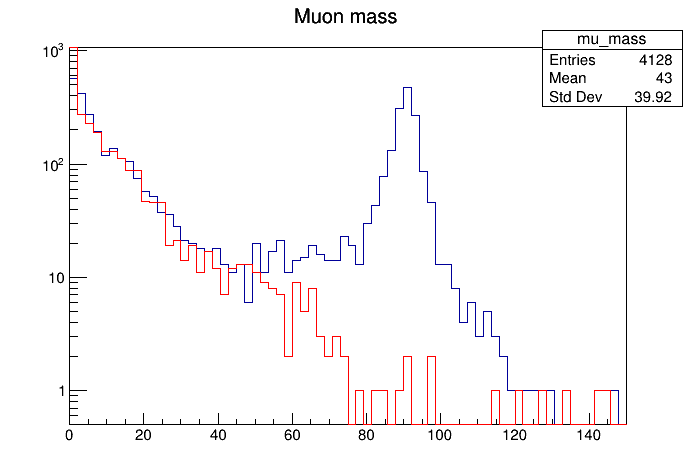

In [4]:
are_os = lambda x,y: x.charge*y.charge<0
h_mu_mass_os = ROOT.TH1F("mu_mass","Muon mass",70,0,150) 
h_mu_mass_ss = ROOT.TH1F("mu_mass","Muon mass",70,0,150)

c=ROOT.TCanvas()

for i in range(tr.GetEntries()):
    tr.GetEntry(i)
    muons=get_collection(tr,"muontracks")
    for mi in range(len(muons)):
        for mj in range(mi):
            if(are_os(muons[mi],muons[mj])):
                h_mu_mass_os.Fill((muons[mi].p4+muons[mj].p4).M())
            else:
                h_mu_mass_ss.Fill((muons[mi].p4+muons[mj].p4).M())
c.Draw()
c.SetLogy()
h_mu_mass_os.Draw()
h_mu_mass_ss.SetLineColor(ROOT.kRed)
h_mu_mass_ss.Draw("same")

 FCN=49.3888 FROM MIGRAD    STATUS=CONVERGED    1280 CALLS        1281 TOTAL
                     EDM=2.4394e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           5.37704e+04   1.20480e+04   6.46401e+00  -2.40969e-07
   2  p1           5.52710e+01   1.89144e+01   3.01906e-03  -6.99502e-04
   3  p2           1.06371e+01   2.48389e+00   2.50324e-04   8.89216e-03
   4  p3          -1.47243e-01   3.07754e-02   5.12346e-06   4.42758e-01
   5  p4           8.68362e-04   2.45436e-04   8.01491e-08   2.55934e+01


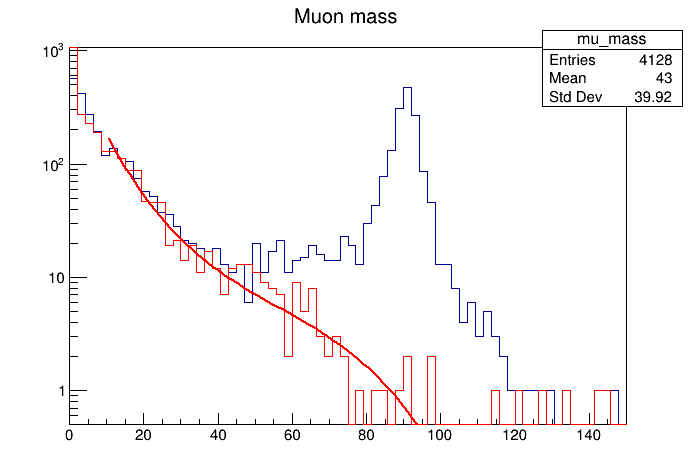

In [5]:
c.Draw()
mu_bgm = 10
mu_bgM = 150

bkg = ROOT.TF1("exp_1", "[0]/[1]* TMath::Exp(-([2]*x + [3]*x*x + [4]*x*x*x )/[1])", mu_bgm, mu_bgM)
bkg.SetParameters(1000,20,1,1,0.001)

h_mu_mass_ss.Fit(bkg,"SR")

 FCN=94.2496 FROM MIGRAD    STATUS=CONVERGED    1550 CALLS        1551 TOTAL
                     EDM=4.2538e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           2.51348e+04   2.87755e+03   3.58180e+00   2.24171e-07
   2  p1           1.57673e+01   1.33319e+00   7.70752e-04   7.47839e-04
   3  p2           3.19425e+03   9.77575e+01   4.46550e-01   3.43927e-07
   4  p3           9.07393e+01   8.41707e-02   3.90420e-04   2.61017e-04
   5  p4           3.16351e+00   1.12594e-01   4.93948e-04  -1.82568e-03
   6  p5           3.75873e+00   1.96667e-01   4.77509e-05  -7.46421e-03
   7  p6          -6.08369e-02   3.02912e-03   5.94964e-07  -1.84975e-01
   8  p7           3.10790e-04   1.60238e-05   6.26506e-09  -2.05363e+00


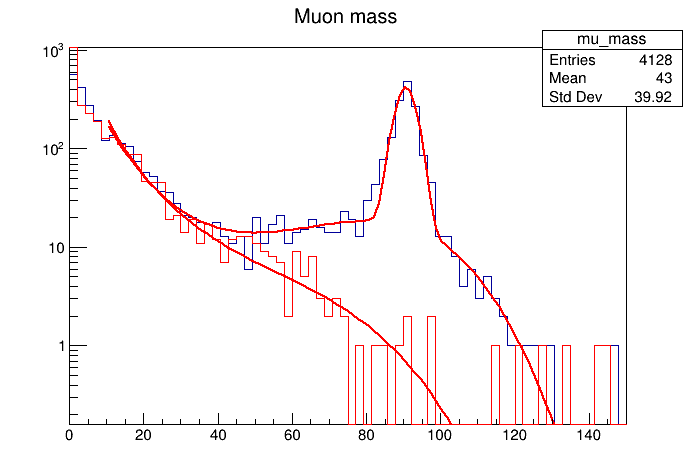

In [6]:
c.Draw()
os_fit = ROOT.TF1("exp+gaus", "[0]/[1]*exp(-([5]*x+[6]*x*x+[7]*x*x*x)/[1])+[2]*1/([4]*TMath::Sqrt(2*TMath::Pi()))*exp(-(x-[3])*(x-[3])/(TMath::Sqrt(2)*[4]*[4]))", mu_bgm, mu_bgM)
os_fit.SetParameters(1000,20,1000,90,10,1,1,0.001)

h_mu_mass_os.Fit(os_fit,"SR")

In [ ]:
print(bkg.Integral(80,100))
print(h_mu_mass_ss.Integral(h_mu_mass_ss.FindBin(80),h_mu_mass_ss.FindBin(100)))

In [ ]:
print(os_fit.Integral(80,100))
print(h_mu_mass_os.Integral(h_mu_mass_os.FindBin(80),h_mu_mass_os.FindBin(100)))

In [ ]:
print(h_mu_mass_os.Integral())
print(h_mu_mass_ss.Integral())

**Eseguo un taglio**

In [ ]:
are_os = lambda x,y: x.charge*y.charge<0
h_mu_mass_os = ROOT.TH1F("mu_mass","Muon mass",50,80,100) 
h_mu_mass_ss = ROOT.TH1F("mu_mass","Muon mass",50,80,100)

c=ROOT.TCanvas()

for i in range(tr.GetEntries()):
    tr.GetEntry(i)
    muons=get_collection(tr,"muontracks")
    for mi in range(len(muons)):
        for mj in range(mi):
            s=(muons[mi].p4+muons[mj].p4).M()
            if(s<100 and s>80):
                if(are_os(muons[mi],muons[mj])):
                    h_mu_mass_os.Fill(s)
                else:
                    h_mu_mass_ss.Fill(s)
c.Draw()

h_mu_mass_os.Scale(1/(h_mu_mass_os.Integral()))
h_mu_mass_os.Draw("SAME,hist")

h_mu_mass_ss.SetLineColor(ROOT.kRed)
h_mu_mass_ss.Scale(1/(h_mu_mass_ss.Integral()))
h_mu_mass_ss.Draw("hist")

Passaggi per le grandezze alternative attorno ai picchi

In [ ]:
h_chi = ROOT.TH1F("muontracks_chi2","muontracks_chi2", 100, 0, 2)
h_chi_f = ROOT.TH1F("muontracks_chi2","muontracks_chi2", 100, 0, 2)
c1 = ROOT.TCanvas()

for i in range(tr.GetEntries()):
    tr.GetEntry(i)
    muons=get_collection(tr,"muontracks")
    for mi in range(len(muons)):
        chi2 = tr.muontracks_chi2[mi]
        h_chi.Fill(chi2)
        for mj in range(mi):
            s=(muons[mi].p4+muons[mj].p4).M()
            if(s<100 and s>80):
                h_chi_f.Fill(tr.muontracks_chi2[mj])
c1.Draw()

h_chi.Scale(1/h_chi.Integral())
h_chi.Draw("hist")

h_chi_f.SetLineColor(ROOT.kRed)
h_chi_f.Scale(1/h_chi_f.Integral())
h_chi_f.Draw("SAME,hist")

In [ ]:
h_dz = ROOT.TH1F("muontracks_dz","muontracks_dz", 100, 0, 0.01)
h_dz_f = ROOT.TH1F("muontracks_dz","muontracks_dz", 100, 0, 0.01)
c2 = ROOT.TCanvas()

for i in range(tr.GetEntries()):
    tr.GetEntry(i)
    muons=get_collection(tr,"muontracks")
    for mi in range(len(muons)):
        dz = tr.muontracks_dz[mi]
        h_dz.Fill(dz)
        for mj in range(mi):
            s=(muons[mi].p4+muons[mj].p4).M()
            if(s<100 and s>80):
                h_dz_f.Fill(tr.muontracks_dz[mj])
c2.Draw()

h_dz_f.SetLineColor(ROOT.kRed)
h_dz_f.Scale(1/h_dz_f.Integral())
h_dz_f.Draw("hist")

h_dz.Scale(1/h_dz.Integral())
h_dz.Draw("SAME,hist")



In [ ]:
h_dB = ROOT.TH1F("muontracks_dB","muontracks_dB", 100, 0, 0.006)
h_dB_f = ROOT.TH1F("muontracks_dB","muontracks_dB", 100, 0, 0.006)
c3 = ROOT.TCanvas()

for i in range(tr.GetEntries()):
    tr.GetEntry(i)
    muons=get_collection(tr,"muontracks")
    for mi in range(len(muons)):
        dB = tr.muontracks_dB[mi]
        h_dB.Fill(dB)
        for mj in range(mi):
            s=(muons[mi].p4+muons[mj].p4).M()
            if(s<100 and s>80):
                h_dB_f.Fill(tr.muontracks_dB[mj])
c3.Draw()

h_dB_f.SetLineColor(ROOT.kRed)
h_dB_f.Scale(1/h_dB_f.Integral())
h_dB_f.Draw("hist")

h_dB.Scale(1/h_dB.Integral())
h_dB.Draw("SAME,hist")

In [ ]:
h_id = ROOT.TH1F("muontracks_isoD","muontracks_isoD", 100, 0.1, 10)
h_id_f = ROOT.TH1F("muontracks_isoD","muontracks_isoD", 100, 0.1, 10)
c4 = ROOT.TCanvas()

for i in range(tr.GetEntries()):
    tr.GetEntry(i)
    muons=get_collection(tr,"muontracks")
    for mi in range(len(muons)):
        isd = tr.muontracks_isoDeposits[mi]
        h_id.Fill(isd)
        for mj in range(mi):
            s=(muons[mi].p4+muons[mj].p4).M()
            if(s<100 and s>80):
                h_id_f.Fill(tr.muontracks_isoDeposits[mj])
c4.Draw()

h_id.Scale(1/h_id.Integral())
h_id.Draw("hist")

h_id_f.SetLineColor(ROOT.kRed)
h_id_f.Scale(1/h_id_f.Integral())
h_id_f.Draw("SAME,hist")